In [1]:
from meta_opt.utils.experiment_utils import make, process_results, bcolors, plot, get_final_cparams

import os
import matplotlib.pyplot as plt
from IPython.display import HTML
import itertools
import dill as pkl

# Load

In [65]:
# configuration
CFG = {
    # training options are None because we arent training :)
    'workload': None,
    'num_iters': None,
    'eval_every': None,
    'num_eval_iters': None,
    'batch_size': None,
    'full_batch': True,
    'reset_every': None,

    # experiment options
    'experiment_name': 'mnist_fullbatch',
    'load_checkpoint': True,
    'overwrite': False,  # whether to allow us to overwrite existing checkpoints or throw errors
    'directory': os.path.abspath("."),
}

results = make(CFG)  # save to temp var `_results` so that we dont immediately overwrite `results` in case somethings wrong
processed_results = process_results(CFG, results)
# processed_results = pkl.load(open('{}/data/{}_processed.pkl'.format(CFG['directory'], CFG['experiment_name']), 'rb'))

using cpu for jax
results will be stored at: /Users/evandigiorno/Desktop/meta-opt/data/mnist_fullbatch_*.pkl
we will try to load experiment checkpoint first
	loaded checkpoint from /Users/evandigiorno/Desktop/meta-opt/data/mnist_fullbatch_raw.pkl, containing ['cf', 'cf_3', 'cf_0.1', 'ncf', 'ncf_0.1', 'sgd', 'momentum', 'adamw', 'hgd']
note: using full_batch means we will never eval
cannot save processed results with existing processed results and `overwrite=False`


In [58]:
# from meta_opt.utils.experiment_utils import save_checkpoint
# results = {}
# for k in r0.keys():
#     results[k] = [r0[k][0], r1[k][0], r2[k][0], r3[k][0], r4[k][0], r5[k][0]]
#     for i in range(3):
#         results[k][i]['args']['experiment_name'] = 'cifar_pretrained'
# save_checkpoint(CFG, results)

Saved checkpoint  to /Users/evandigiorno/Desktop/meta-opt/data/cifar_pretrained_raw.pkl


# Plot
Plot annd also animate the values taken by the $\{M_h\}_{h=1}^H$ coefficients during training. Each $M_h$ multiplies a disturbance from $h$ training steps ago (i.e. 0 is most recent in this plot).

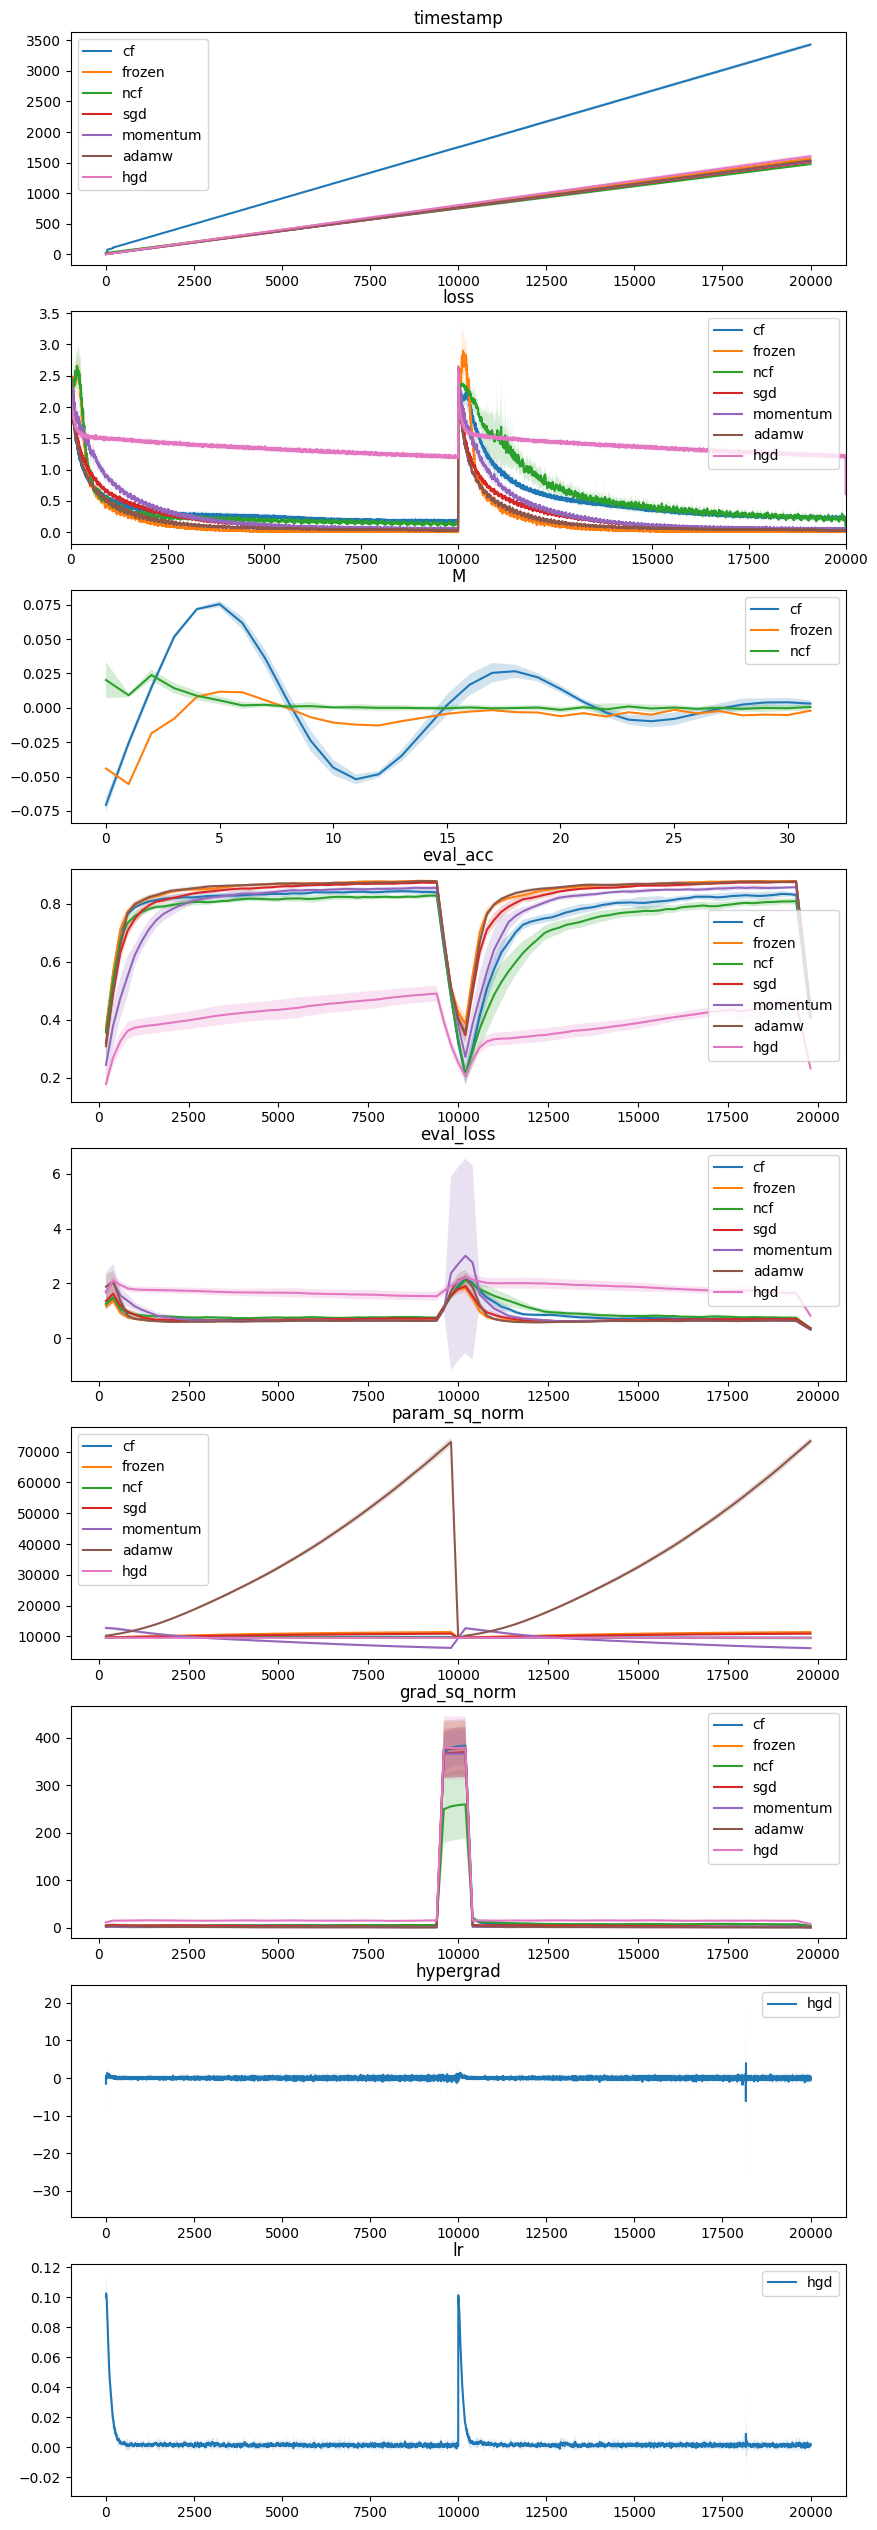

In [63]:
# ----------------------------------------
# plot a particular set of experiments
# ----------------------------------------
keys_to_plot = [
    'sgd',
    'momentum',
    'adamw',
    # 'rmsprop',
    'hgd',
    'ncf',
    'cf',
    'frozen',
]

# ----------------------------------------
# OR just plot em via regex
# ----------------------------------------
# keys_to_plot = '.*long.*'  # specific regex
keys_to_plot = '.*'  # anything

(fig, ax), anim = plot(results, processed_results, keys_to_plot, anim_bounds=(-0.15, 0.05))
ax[1].set_xlim(0, 20000)
# ax[1].set_ylim(0.,0.1)
# ax[2].set_ylim(0.5, 0.9)
# ax[3].set_ylim(0.95, 0.99)
# ax[4].set_ylim(-0.1, 40)
# ax[5].set_ylim(-0.05, 0.05)
# plt.savefig(f'{DIR}/figs/{CFG['experiment_name']}.pdf')
for a in ax: a.legend()
plt.show()

h = HTML(anim.to_html5_video())
display(h)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


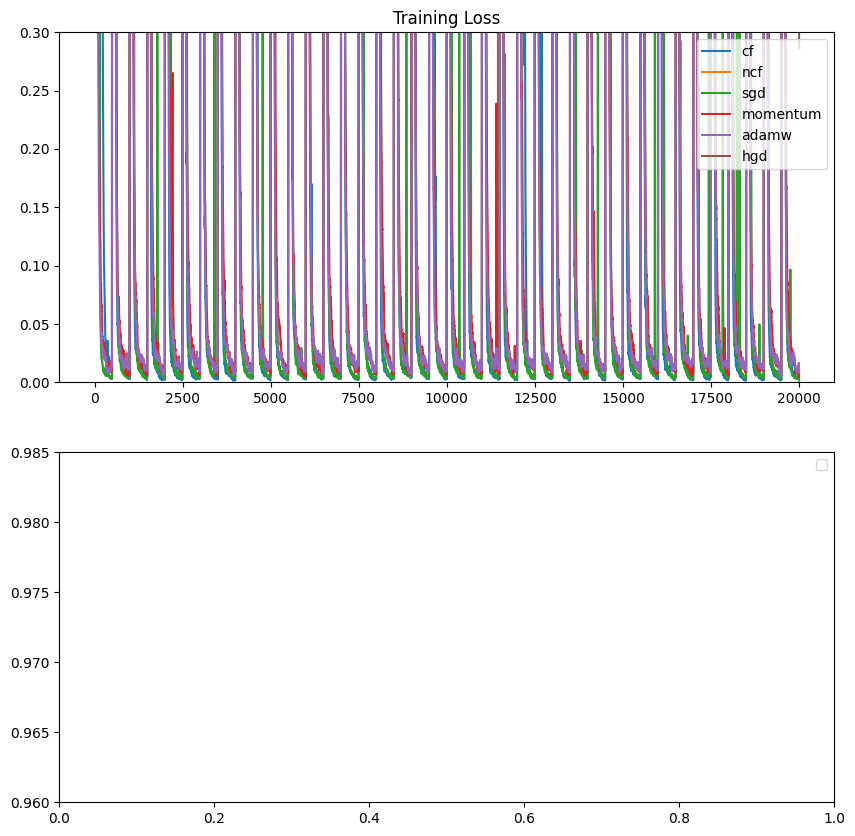

In [5]:
from time import perf_counter
from typing import Tuple
from collections import defaultdict
from copy import deepcopy
import tqdm
import dill as pkl
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import matplotlib.animation as animation
from meta_opt.utils.experiment_utils import animate

def custom_plot(results, processed_results, keys_to_plot, anim_downsample_factor=200, anim_bounds=(-0.4, 0.1)):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    Ms = {}
    for i, stat_key in enumerate(processed_results.keys()):
        if stat_key not in ['loss', 'eval_acc']: continue
        else: i = ['loss', 'eval_acc'].index(stat_key)
        ax[i].set_title('Training Loss' if stat_key == 'loss' else 'Evaluation Accuracy')
        for experiment_name in processed_results[stat_key].keys():
            if (isinstance(keys_to_plot, list) and experiment_name not in keys_to_plot) or (isinstance(keys_to_plot, str) and not re.match(keys_to_plot, experiment_name)): 
                # print(f'skipped {experiment_name}')
                continue
            ts, avgs, stds = processed_results[stat_key][experiment_name]['t'], processed_results[stat_key][experiment_name]['avg'], processed_results[stat_key][experiment_name]['std']
            if avgs.ndim == 2:  # how to handle stats that are vectors (such as the Ms for scalar meta-opt)
                Ms[experiment_name] = (ts, avgs)
                ax[i].plot(ts, avgs.sum(axis=-1), label=experiment_name)
                stds = ((stds ** 2).sum(axis=-1)) ** 0.5
                ax[i].fill_between(ts, avgs.sum(axis=-1) - 1.96 * stds, avgs.sum(axis=-1) + 1.96 * stds, alpha=0.2)
                # for j in range(avgs.shape[1]):
                #     ax[i].plot(ts, avgs[:, j], label=f'{experiment_name} {str(j)}')
                #     ax[i].fill_between(ts, avgs[:, j] - 1.96 * stds[:, j], avgs[:, j] + 1.96 * stds[:, j], alpha=0.2)
            else:
                if stat_key in ['loss', 'grad_sq_norm', 'eval_acc', 'eval_loss']:
                    n = 10
                    kernel = np.array([1 / n,] * n)
                    avgs = np.convolve(avgs, kernel)[n // 2:n // 2 + avgs.shape[0]]
                    stds = np.convolve(stds ** 2, kernel ** 2)[n // 2:n // 2 + stds.shape[0]] ** 0.5
                maps = {'metaopt_cf_long_noadam': 'counterfactual',
                       'metaopt_ncf_long_noadam': 'noncounterfactual'}
                ax[i].plot(ts, avgs, label=maps[experiment_name] if experiment_name in maps else experiment_name)
                ax[i].fill_between(ts, avgs - 1.96 * stds, avgs + 1.96 * stds, alpha=0.2)
    for a in ax: a.legend()
    # anim = animate(results, Ms, anim_downsample_factor, anim_bounds)
    anim = None
    # plt.close()
    return (fig, ax), anim

(fig, ax), anim = custom_plot(results, processed_results, keys_to_plot, anim_bounds=(-0.05, 0.05))
ax[0].set_ylim(0.,0.3)
ax[1].set_ylim(0.96, 0.985)
# plt.savefig('{}/figs/{}_losses.pdf'.format('.', CFG['experiment_name']))
for a in ax: a.legend()
# plt.show()

# h = HTML(anim.to_html5_video())
# display(h)